<a href="https://colab.research.google.com/github/alouwyck/vives-machine-learning/blob/main/10_decision_trees/2_decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

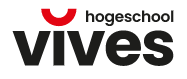<br>


**MACHINE LEARNING FUNDAMENTALS**<br>
Academiejaar 2023-2024<br>
Andy Louwyck

---



---



# **DECISION TREES - PART II**

Deze notebook werd opgesteld door Dr. Stefaan Haspeslagh, onderzoeker en lector AI aan de Vives Hogeschool.

## Verschillende algoritmen

In het voorgaande deel hebben we een high level algoritme gezien om een decision tree te leren, gegeven een dataset.
Er bestaan echter verschillende decision tree algoritmen, die elk hun speciefieke eigenschappen hebben. De meest populaire algoritmen zijn: ID3, C4.5 en CART. We zetten kort even de verschillen tussen de algoritmen op een rijtje, zonder in detail te treden.

**ID3**

= Iterative Dichotomiser 3
- uitgevonden door Ross Quinlan in 1986
- is een greedy algoritme
- ontworpen voor categorische targets
- opletten voor overfitting!
- geen ondersteuning voor numerieke features en missing values



*Pseudocode:*

```
ID3(examples, target_attribute, attributes)
  Create a Root node for the tree
  If all examples are positive:
      return the single-node tree Root, with label = +.
  If all examples are negative:
      return the single-node tree Root, with label = -.
  If number of predicting attributes is empty:
      return the single node tree Root, with label =
          most common value of the target attribute
          in the examples.        
  Else
    A = The Attribute that best classifies examples
      Decision Tree attribute for Root = A.
    For each possible value, vi, of A:
      Add a new tree branch below Root
        corresponding to the test A = vi.
      Let Examples(vi), be the subset of examples
        that have the value vi for A
      If Examples(vi) is empty:
        Then below this new branch add a leaf node with label =
        most common target value in the examples
      Else
        below this new branch add the subtree
          ID3(Examples(vi), Target_Attribute, Attributes – {A})
  End
  return Root

```

Zie ook de notebook over ID3.

**C4.5**

C4.5 is de opvolger van ID3 en biedt ondersteuning voor numerieke features. Waar ID3 enorm onderhevig is aan overfitting, probeert C4.5 dit euvel op te lossen door middel van pruning.

Belangrijke eigenschappen:
- pruning om overfitting tegen te gaan
- inschatting van de diepte van de beslissingsboom
- ondersteunt continue features
- ondersteunt missing values
- verbeterde performantie

**CART**

= Classification and Regression Trees

Dit algoritme is zeer gelijkaardig aan C4.5, maar kan naast classificatie ook voor regressie gebruikt worden en biedt dus ondersteuning voor numerieke targets. In SKLearn is een geoptimaliseerde versie van het CART-algoritme geïmplementeerd.

Belangrijkste eigenschappen:
- leert binaire beslissingsbomen
- ondersteunt zowel categorische als numerieke targets
- **let op**: de implementatie in SKLearn ondersteunt geen categorische features! Er is dus encodering nodig!

## Hyperparameters

Alle algoritmen die we tot nu toe gezien hebben, kampen met hetzelfde probleem: het is heel gemakkelijk (en verleidelijk) om beslissingsbomen te trainen die met **overfitting** kampen.

Als we het proces van herhaaldelijk opsplitsen te vaak herhalen, dan zullen we een beslissingsboom bekomen met heel veel bladeren, met het risico dat elk blad maar met één voorbeeld overeenkomt.

We hebben dus een aantal goede **stopcriteria** nodig om overfitting tegen te gaan. Deze stopcriteria vormen extra **hyperparameters** die getuned moeten worden bij het trainen van een decision tree:

1. Stop het splitsen wanneer de Gini Gain of Information Gain na een splitsing te klein is (**`min_impurity_decrease`**).
2. Een node niet splitsen indien er te weinig voorbeelden bij een node horen (**`min_samples_split`**).
3. Stop het splitsen waneer de boom te diep wordt, d.i. een maximaal aantal niveaus heeft bereikt (**`max_depth`**).

Ofwel kiezen we een waarde voor deze hyperparameters gebaseerd op evaring, of we gaan actief op zoek naar de beste combinatie van waarden voor deze hyperparameters. Dit laatste proces noemen we **grid search**. We zien hiervan straks een voorbeeld.

## Decision trees in Scikit-Learn - continued

In de rest van dit topic beschrijven we het proces om een goede beslissingboom te trainen in sklearn.

- We starten met het inlezen en analyseren van een dataset.
- Daarna splitsen we de dataset op in een trainingset en een validatieset. (De testset laten we hier gemakkelijkheidshalve achterwege.)
- We verkennen verschillende waarden voor de hyperparameters om duidelijk het gevaar van overfitting te illustreren. Dit doen we adhv de gekende tools en metrieken.
- We automatiseren het tunen van de hyperparameters met grid search.

### De Iris-dataset

Om het bovenstaande proces te illusteren, gebruiken we een typische dataset die ingebouwd zit in sklearn. Een beschrijving van de dataset kan je ook hier vinden:
https://archive.ics.uci.edu/ml/datasets/iris.

Deze dataset bevat 150 instanties om irisbloemen in te delen in drie categorieën:
- Iris Setosa
- Iris Versicolour
- Iris Virginica

Van die 150 instanties hebben we de gegevens van 4 features:
1. kelkbladlengte (sepal length) in cm
2. kelkbladbreedte (sepal width) in cm
3. bloembladlengte (petal length) in cm
4. bloembladbreedte (petal width) in cm

Daarnaast weten we uiteraard tot welke categorie elk voorbeeld (instantie) behoort.

### Datapreparatie

We laden de iris dataset in en zetten die om naar een Pandas DataFrame.

In [ ]:
# import statements
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris

In [ ]:
# load the data
data = load_iris()

In [ ]:
# convert to a dataframe
df = pd.DataFrame(data.data, columns=data.feature_names)  # features in data.data
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [ ]:
# describe
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


Het dataframe bevat dus 150 voorbeelden, met de waarden van de 4 features. We voegen nu een extra kolom toe aan het dataframe met de labels (tot welke categorie/soort de bloem behoort).

In [ ]:
# create the species column
df['species'] = data.target  # labels zitten in data.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


De laatste kolom bevat een "label-encodering" van de categorieën. We prefereren de echte labels in de laatste kolom i.p.v. numerieke waarden.
We maken eerst een dictionary aan met de mapping tussen de numerieke waarden en de labels.

In [ ]:
# replace this with the actual names
target = np.unique(data.target)
target_names = np.unique(data.target_names)  # de namen van de labels zitten in data.target_names
targets = dict(zip(target, target_names))
targets

{0: 'setosa', 1: 'versicolor', 2: 'virginica'}

Vervolgens veranderen we de numerieke waarden in de laatste kolom in de labels.

In [ ]:
df['species'] = df['species'].replace(targets)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### Selecteren van features en target

Zoals gewoonlijk selecteren we de features in een matrix `X` en de labels in een vector `y`.

In [ ]:
# extract features and target variables
X = df.drop(columns="species")
y = df["species"]
print(X.iloc[:5, :])
print()
print(y.iloc[:5])

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

0    setosa
1    setosa
2    setosa
3    setosa
4    setosa
Name: species, dtype: object


### Trainen van de decision tree

We splitsen de dataset in een trainingset en een validatieset. We kiezen voor een 60-40 validation split.

In [ ]:
# save the feature name and target variables
feature_names = X.columns
labels = y.unique()

We gebruiken functie `train_test_split` van SKLearn.

In [ ]:
# split the dataset
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                 test_size=0.4,
                                                 random_state=42)  # niet opgeven in praktijk!

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(90, 4)
(90,)
(60, 4)
(60,)


Vervolgens trainen we een decision tree zoals we dat in de vorige notebook hebben gezien.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)  # random_state weglaten in praktijk!
clf.fit(X_train, y_train);

We plotten de decision tree.

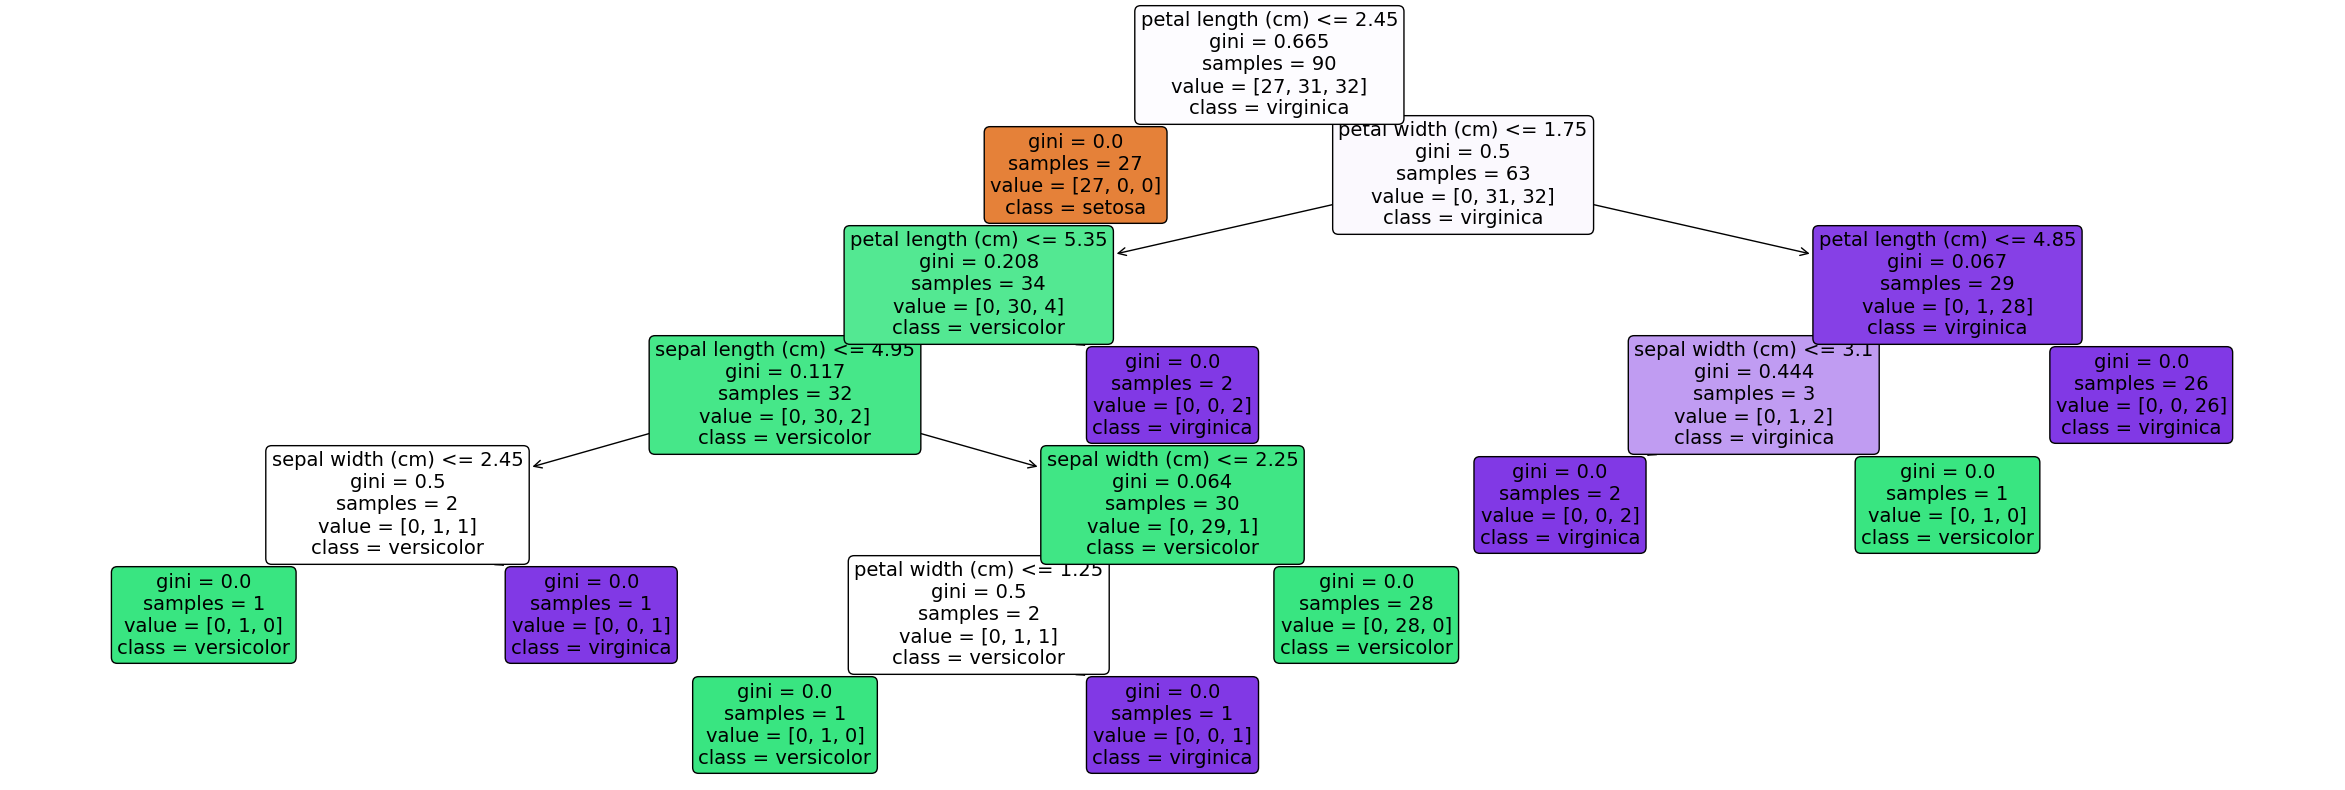

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt

# create figure with specified size
plt.figure(figsize=(30,10))

# create the tree plot
a = tree.plot_tree(clf,
                   # use the feature names stored
                   feature_names = feature_names,
                   # use the class names stored
                   class_names = labels,
                   rounded = True,
                   filled = True,
                   fontsize=14)
# show the plot
plt.show()  # not required in Colab

We kunnen ook een tekstuele versie van de decision tree printen.

In [ ]:
from sklearn.tree import export_text

r = export_text(clf, feature_names=list(feature_names), show_weights=True)
print(r)

|--- petal length (cm) <= 2.45
|   |--- weights: [27.00, 0.00, 0.00] class: setosa
|--- petal length (cm) >  2.45
|   |--- petal width (cm) <= 1.75
|   |   |--- petal length (cm) <= 5.35
|   |   |   |--- sepal length (cm) <= 4.95
|   |   |   |   |--- sepal width (cm) <= 2.45
|   |   |   |   |   |--- weights: [0.00, 1.00, 0.00] class: versicolor
|   |   |   |   |--- sepal width (cm) >  2.45
|   |   |   |   |   |--- weights: [0.00, 0.00, 1.00] class: virginica
|   |   |   |--- sepal length (cm) >  4.95
|   |   |   |   |--- sepal width (cm) <= 2.25
|   |   |   |   |   |--- petal width (cm) <= 1.25
|   |   |   |   |   |   |--- weights: [0.00, 1.00, 0.00] class: versicolor
|   |   |   |   |   |--- petal width (cm) >  1.25
|   |   |   |   |   |   |--- weights: [0.00, 0.00, 1.00] class: virginica
|   |   |   |   |--- sepal width (cm) >  2.25
|   |   |   |   |   |--- weights: [0.00, 28.00, 0.00] class: versicolor
|   |   |--- petal length (cm) >  5.35
|   |   |   |--- weights: [0.00, 0.00, 2.0

Zowel in de grafische als in de tekstuele versie zien we direct het probleem van overfitting:
- De boom is behoorlijk diep en complex, ook al hebben we maar 4 features!
- Het aantal samples in de leafs is soms heel laag...

Een tuning van de hyperparameters is dus zeker nodig!

### Validatie en tuning van hyperparameters

We tonen eerst hoe de relevante evaluatietools gebruikt en de metrieken berekend kunnen worden.
In eerste instantie voorspellen we de labels van de validatieset met de getrainde decision tree.

In [ ]:
val_pred_decision_tree = clf.predict(X_val)

**Confusiematrix**

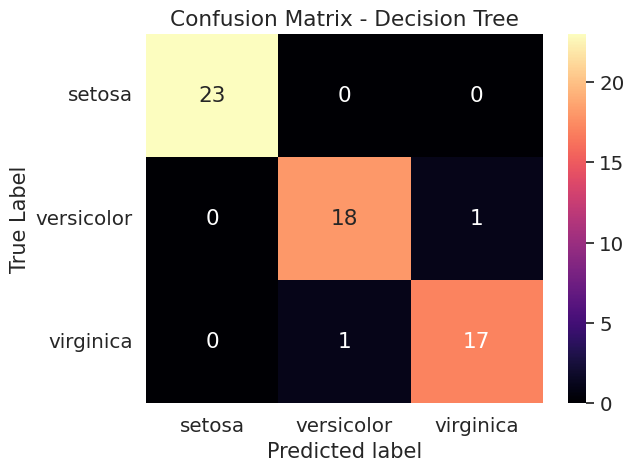

<Figure size 1000x700 with 0 Axes>

In [ ]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

# get the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_val, val_pred_decision_tree)

# turn this into a dataframe
matrix_df = pd.DataFrame(confusion_matrix)

# plot the result
ax = plt.axes();
sns.set(font_scale=1.3);
plt.figure(figsize=(10, 7));
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma");

# set axis titles
ax.set_title('Confusion Matrix - Decision Tree');
ax.set_xlabel("Predicted label", fontsize=15);
ax.set_xticklabels([''] + labels);
ax.set_ylabel("True Label", fontsize=15);
ax.set_yticklabels(list(labels), rotation=0);
plt.show()

**Metrieken**

In [ ]:
# accuracy
metrics.accuracy_score(y_val, val_pred_decision_tree)

0.9666666666666667

In [ ]:
# get the precision score
precision = metrics.precision_score(y_val,
                                    val_pred_decision_tree,
                                    average=None)
# turn it into a dataframe
precision_results = pd.DataFrame(precision, index=labels)

# rename the results column
precision_results.rename(columns={0:'precision'}, inplace =True)
precision_results

,precision
setosa,1.000000
versicolor,0.947368
virginica,0.944444


In [ ]:
# get the recall score
recall = metrics.recall_score(y_val,
                              val_pred_decision_tree,
                              average =None)
recall_results = pd.DataFrame(recall, index= labels)
recall_results.rename(columns ={0:'Recall'}, inplace =True)
recall_results

,Recall
setosa,1.000000
versicolor,0.947368
virginica,0.944444


In [ ]:
# get F1 score
f1 = metrics.f1_score(y_val,
                      val_pred_decision_tree,
                      average=None)
f1_results = pd.DataFrame(f1, index=labels)
f1_results.rename(columns={0:'f1'}, inplace=True)
f1_results

,f1
setosa,1.000000
versicolor,0.947368
virginica,0.944444


In [ ]:
# classification report
print(metrics.classification_report(y_val, val_pred_decision_tree))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        23
  versicolor       0.95      0.95      0.95        19
   virginica       0.94      0.94      0.94        18

    accuracy                           0.97        60
   macro avg       0.96      0.96      0.96        60
weighted avg       0.97      0.97      0.97        60



In [ ]:
# extract importance
importance = pd.DataFrame({'feature': X_train.columns,
                           'importance' : np.round(clf.feature_importances_, 3)})
importance.sort_values('importance', ascending=False, inplace=True)
print(importance)

             feature  importance
2  petal length (cm)       0.539
3   petal width (cm)       0.393
1   sepal width (cm)       0.055
0  sepal length (cm)       0.014


(Uit de SKLearn documentatie: "The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.")

### Overfitting

Ter illustratie proberen we overfitting tegen te gaan door de manuele tuning van één hyperparameter: `max_depth`.

In [ ]:
def eval_tree(max_depth, textual=False):

    print("DEPTH: ", max_depth)

    clf = DecisionTreeClassifier(max_depth=max_depth, random_state = 42)
    clf.fit(X_train, y_train)

    if not textual:
        #import relevant packages
        from sklearn import tree
        import matplotlib.pyplot as plt
        #plt the figure, setting a black background
        plt.figure(figsize=(30,10)) # , facecolor ='k')
        #create the tree plot
        a = tree.plot_tree(clf,
                           #use the feature names stored
                           feature_names = feature_names,
                           #use the class names stored
                           class_names = labels,
                           rounded = True,
                           filled = True,
                           fontsize=14)
        #show the plot
        plt.show()
    else:
        from sklearn.tree import export_text
        r = export_text(clf, feature_names=list(feature_names), show_weights=True)
        print(r)

    # accuracy on training set
    train_pred_decision_tree = clf.predict(X_train)
    print("Accuracy on training set: ", metrics.accuracy_score(y_train, train_pred_decision_tree))

    # accuracy on validation set
    val_pred_decision_tree = clf.predict(X_val)
    print("Accuracy on validation set: ", metrics.accuracy_score(y_val, val_pred_decision_tree))
    print("")

Uittesten voor `max_depth` gelijk aan 10, 3 en 2:

DEPTH:  10


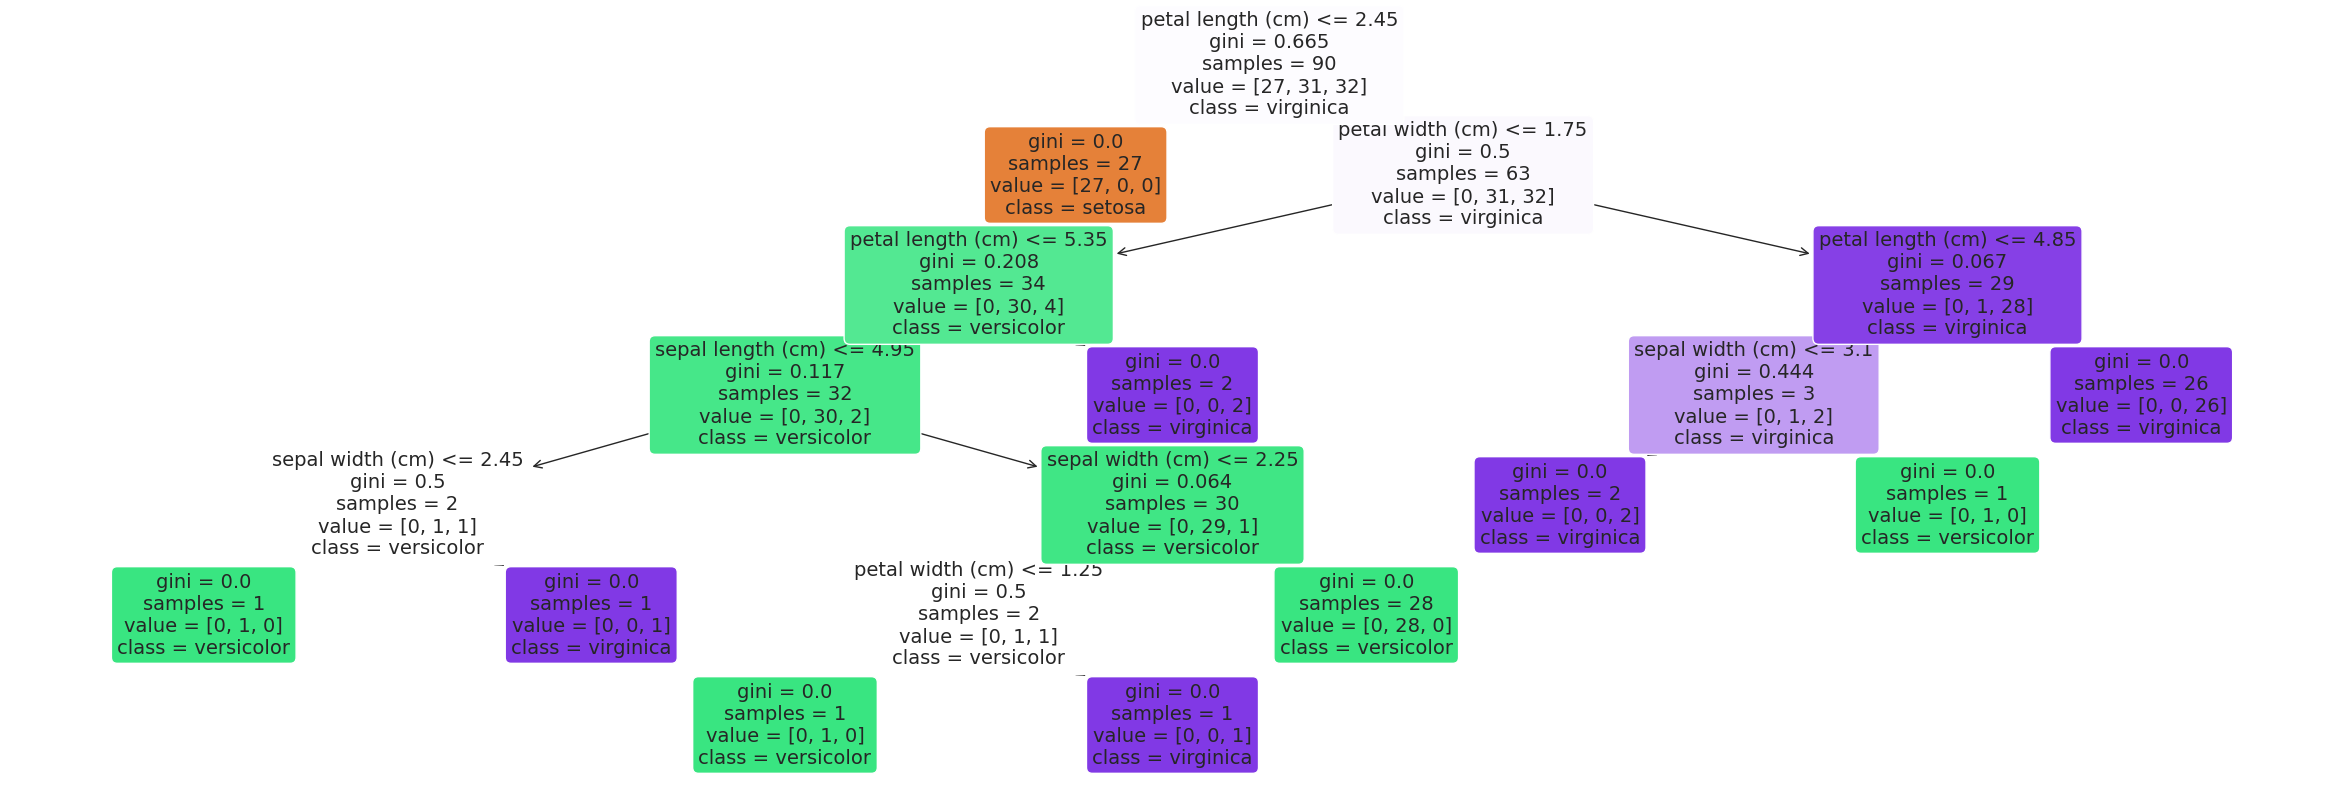

Accuracy on training set:  1.0
Accuracy on validation set:  0.9666666666666667

DEPTH:  3


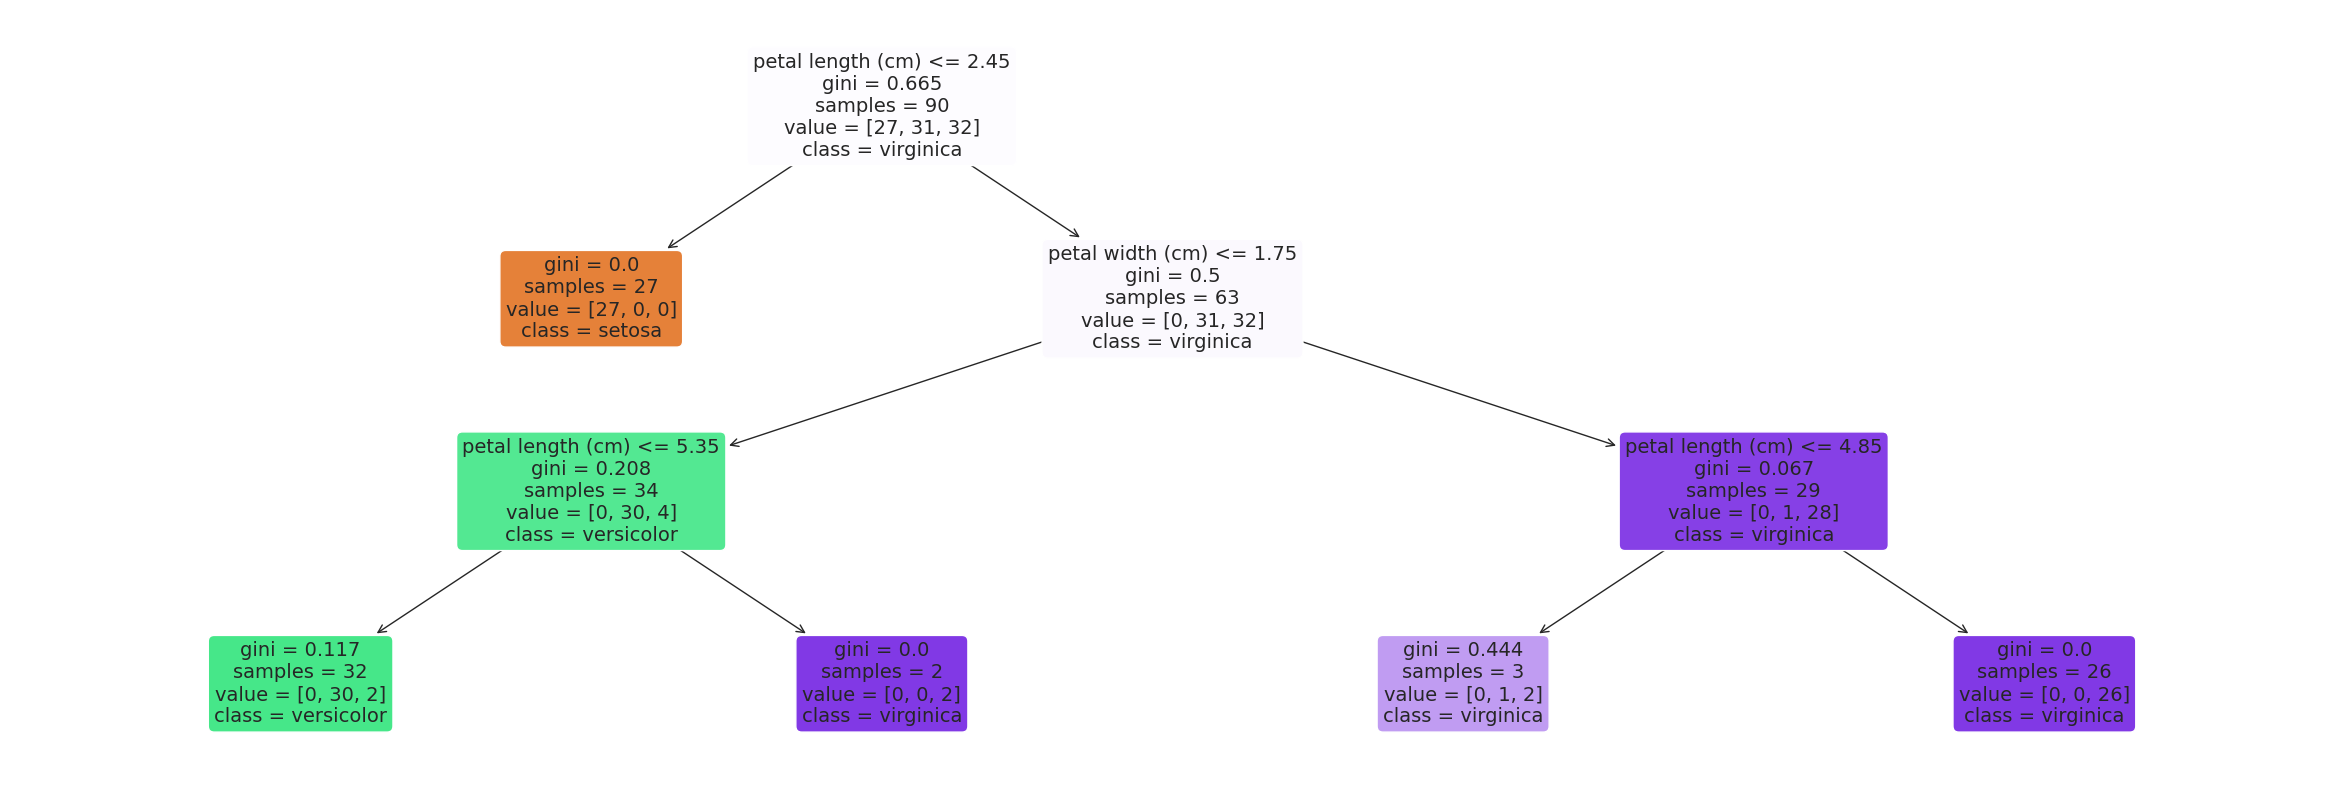

Accuracy on training set:  0.9666666666666667
Accuracy on validation set:  0.9833333333333333

DEPTH:  2


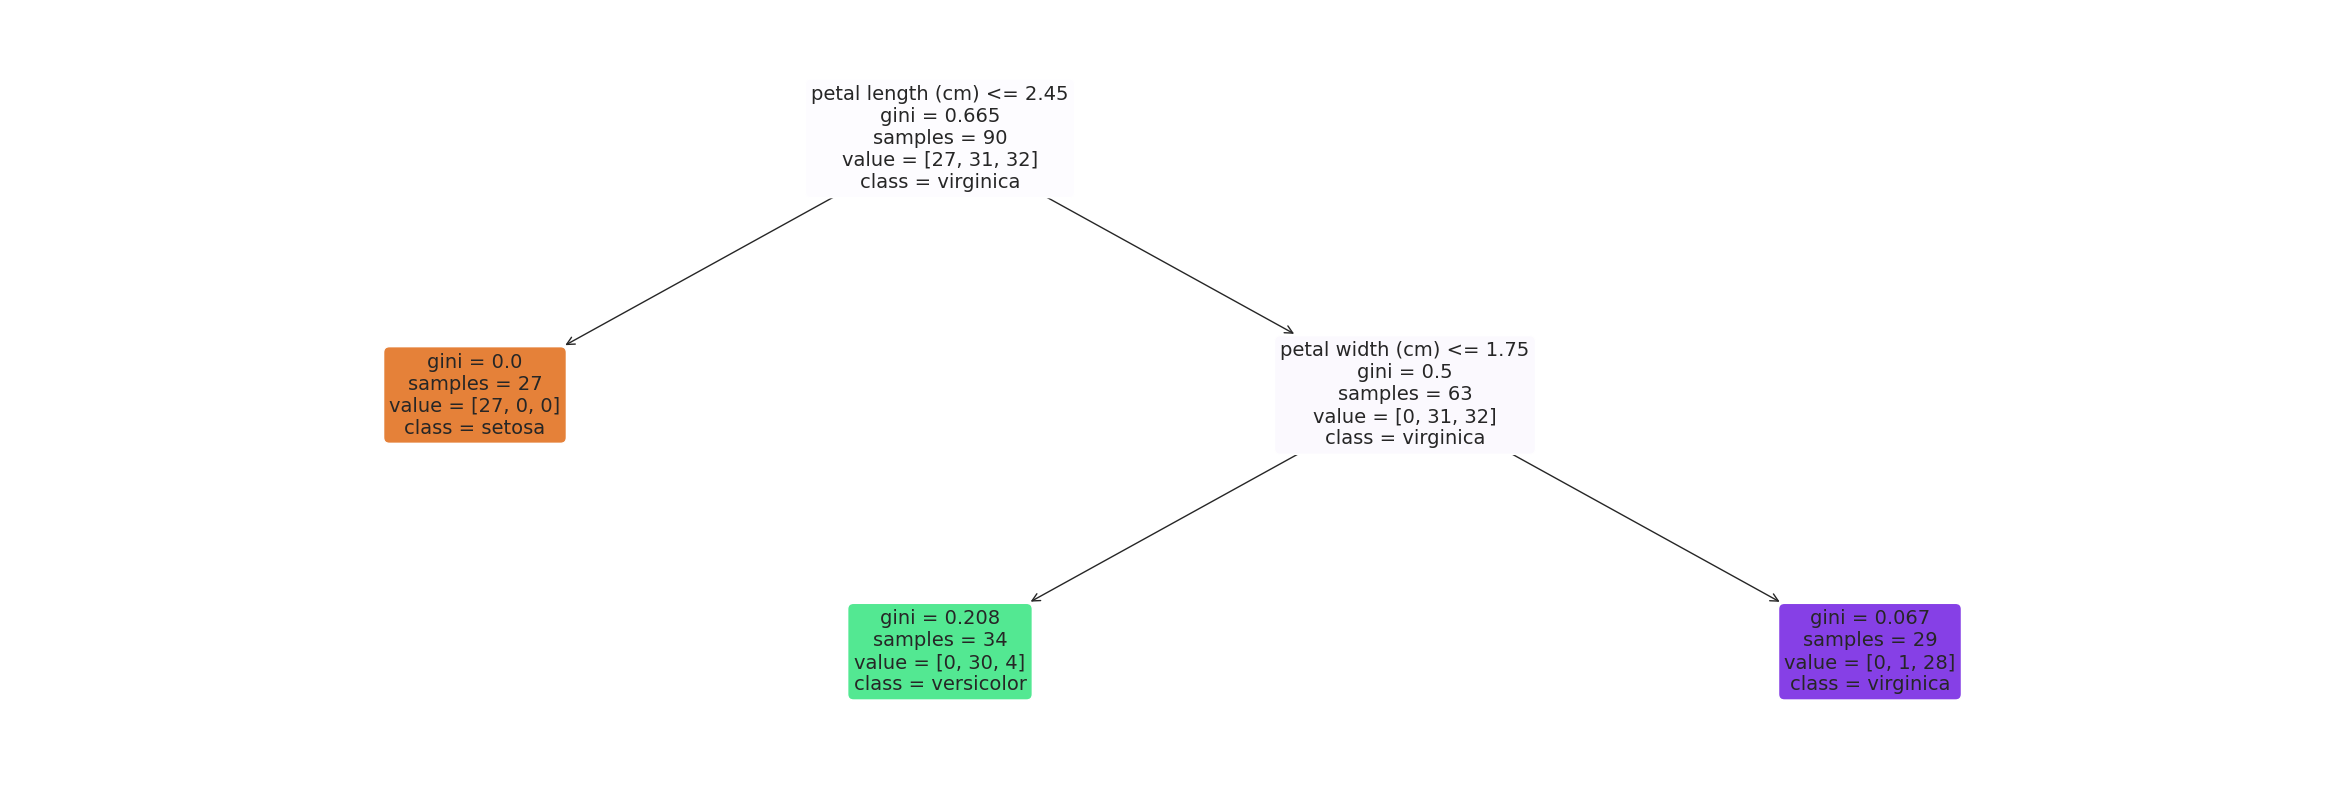

Accuracy on training set:  0.9444444444444444
Accuracy on validation set:  0.9833333333333333



In [ ]:
for d in [10, 3, 2]:
    eval_tree(d)

### Grid search

In de vorige sectie hebben we een manuele tuning van de hyperparameter `max_depth` uitgevoerd. Er zijn echter meerdere hyperparameters die elk verschillende waarden kunnen aannemen. Het wordt al snel onhaalbaar om een manuele tuning uit te voeren. Daarom wordt gebruik gemaakt van **grid search** om de beste combinatie van hyperparameters te zoeken. We illusteren dit voor de hyperparameters `max_depth` en `min_samples_split`.

In [ ]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'max_depth': [1,2,3,4,5],
                     'min_samples_split': [2,4,6,8,10]}]

scores = ['accuracy']
for score in scores:

    print()
    print(f"Tuning hyperparameters for {score}")
    print()

    clf = GridSearchCV(
        DecisionTreeClassifier(random_state=42), tuned_parameters,
        scoring = f'{score}'
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds,
                                 clf.cv_results_['params']):
        print(f"{mean:0.3f} (+/-{std*2:0.03f}) for {params}")


Tuning hyperparameters for accuracy

Best parameters set found on development set:

{'max_depth': 3, 'min_samples_split': 2}

Grid scores on development set:
0.600 (+/-0.163) for {'max_depth': 1, 'min_samples_split': 2}
0.600 (+/-0.163) for {'max_depth': 1, 'min_samples_split': 4}
0.600 (+/-0.163) for {'max_depth': 1, 'min_samples_split': 6}
0.600 (+/-0.163) for {'max_depth': 1, 'min_samples_split': 8}
0.600 (+/-0.163) for {'max_depth': 1, 'min_samples_split': 10}
0.878 (+/-0.191) for {'max_depth': 2, 'min_samples_split': 2}
0.878 (+/-0.191) for {'max_depth': 2, 'min_samples_split': 4}
0.878 (+/-0.191) for {'max_depth': 2, 'min_samples_split': 6}
0.878 (+/-0.191) for {'max_depth': 2, 'min_samples_split': 8}
0.878 (+/-0.191) for {'max_depth': 2, 'min_samples_split': 10}
0.900 (+/-0.191) for {'max_depth': 3, 'min_samples_split': 2}
0.900 (+/-0.191) for {'max_depth': 3, 'min_samples_split': 4}
0.900 (+/-0.191) for {'max_depth': 3, 'min_samples_split': 6}
0.900 (+/-0.191) for {'max_depth'

Grid search vindt de volgende beste combinatie:
- `max_depth = 3`
- `min_samples_split = 2`

### Plotting a decision surface

Een **decision surface** kan gebruikt worden als een alternatieve visuele inspectie voor overfitting. Het is een populaire diagnostische tool om beter te begrijpen welke beslissingen er door een classificatie-algoritme werden gemaakt. Het is m.a.w. een tool om te zien hoe het algoritme de input feature space heeft opgedeeld adhv de class labels. Hier demonstreren we het uiteraard voor een classification tree, maar het kan ook toegepast worden bij andere classifiers. Zie bijv.

https://machinelearningmastery.com/plot-a-decision-surface-for-machine-learning/

In [ ]:
# import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [ ]:
# iris dataset opnieuw inladen
iris = load_iris()

<ipython-input-42-d4fbe06bd8c7>:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[index, 0],
<ipython-input-42-d4fbe06bd8c7>:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[index, 0],
<ipython-input-42-d4fbe06bd8c7>:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[index, 0],
<ipython-input-42-d4fbe06bd8c7>:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[index, 0],
<ipython-input-42-d4fbe06bd8c7>:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[index, 0],
<ipython-input-42-d4fbe06bd8c7>:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[index, 0],


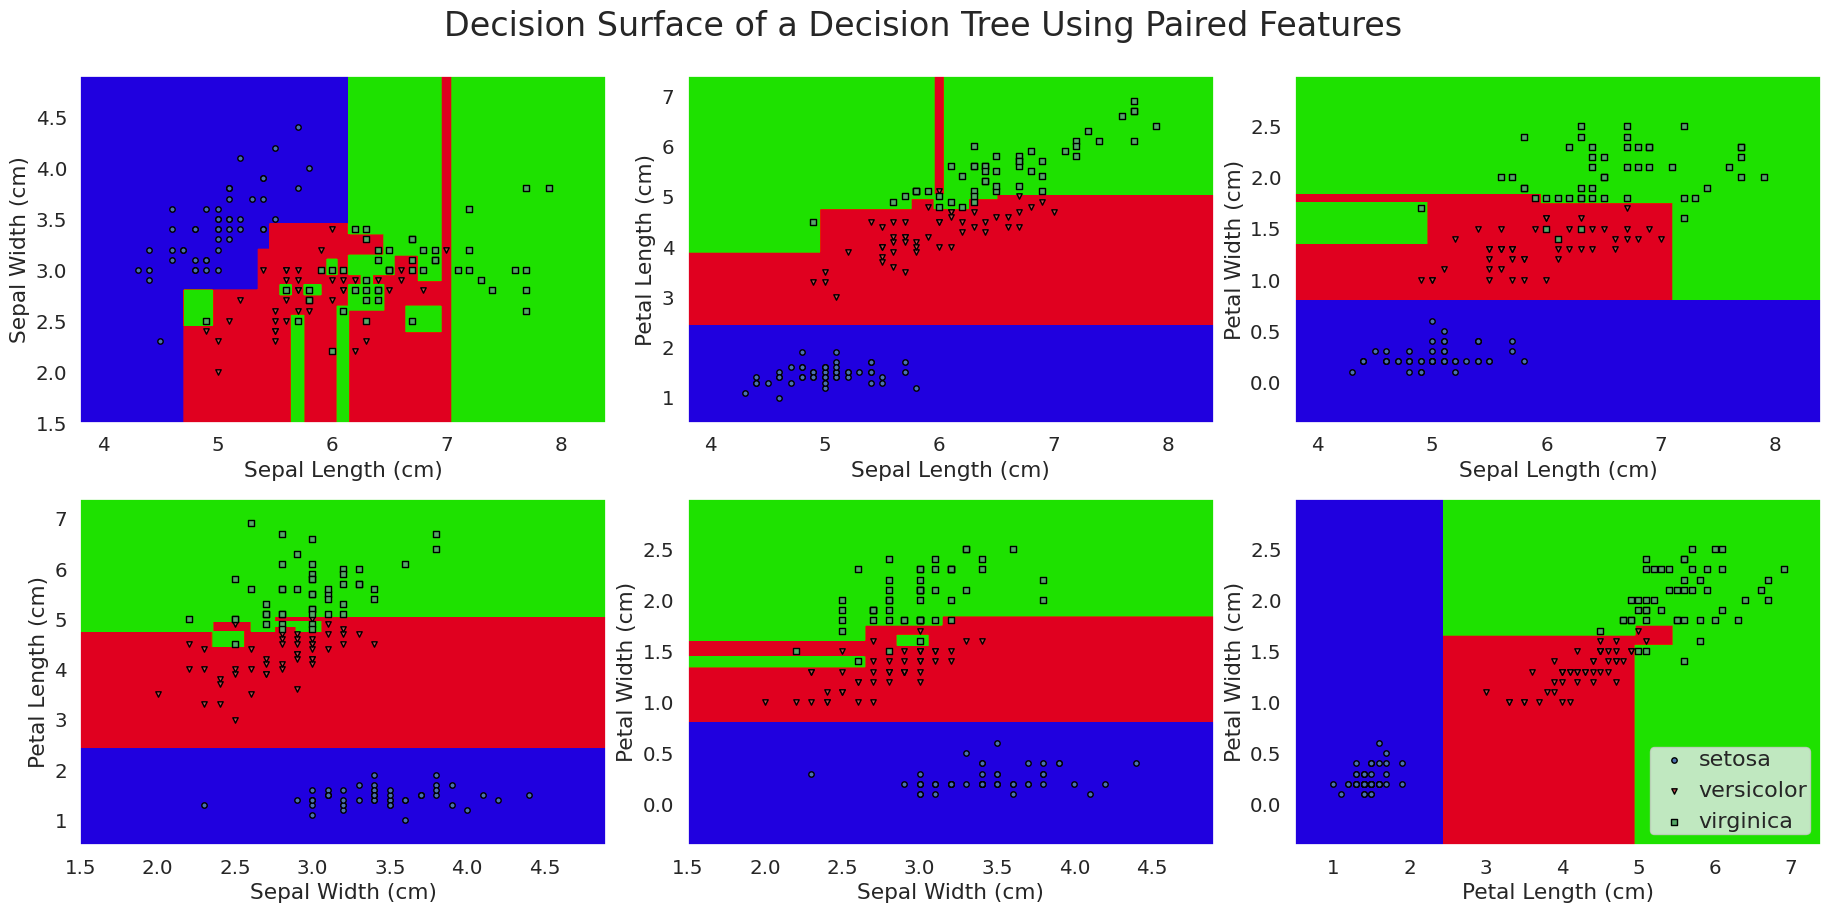

In [ ]:
# Define a variable to establish three classes/species.
class_count = 3
# Define standard RGB color scheme for visualizing ternary classification in order to match the color map used later.
plot_colors = 'brg'
# Define marker options for plotting class assignments of training data.
markers = 'ovs'
# We also need to establish a resolution for plotting.  I favor clean powers of ten, but this is not by any means a hard and fast rule.
plot_res = 0.01

# Set the size of the figure used to contain the subplots to be generated.
plt.figure(figsize=(20,10))

# Create an empty list of models to store the results of each pairwise model fit.
models = []

# Use enumerate() to define the possible pairs of features available and iterate over each pair.
for pair_index, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                           [1, 2], [1, 3],
                                                   [2, 3] ]):

    # We only take the two features corresponding to the pair in question...
    X, y = iris.data[:, pair] , iris.target

    # ... to fit the decision tree classifier model.
    # model = DecisionTreeClassifier(max_depth=3).fit(X, y)
    model = DecisionTreeClassifier().fit(X, y)

    # Append the results to the models list
    models.append(model)

    # Establish a two row by three column subplot array for plotting.
    plt.subplot(2, 3, pair_index + 1)

    # Define appropriate x and y ranges for each plot...
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    # ... and use each range to define a meshgrid to use as the plotting area.
    xx, yy = np.meshgrid(np.arange(x_min,
                                   x_max,
                                   plot_res),
                         np.arange(y_min,
                                   y_max,
                                   plot_res) )
    # Use plt.tight_layout() to establish spacing of the subplots.
    plt.tight_layout(h_pad = 0.5,
                     w_pad = 0.5,
                       pad = 4.0 )

    # Predict the classification of each point in the meshgrid based on the calculated model above.
    # The numpy methods .c_() and .ravel() reshape our meshgrid values into a format compatible with our model.predict() method,
    Z = model.predict(np.c_[xx.ravel(),
                            yy.ravel() ])
    # Reshape the predictions to match xx...
    Z = Z.reshape(xx.shape)
    # ... and prepare a contour plot that reflects the predictions .
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.brg)

    # Define the subplot axis labels after title casing while preserving case on the unit of measure
    plt.xlabel(iris.feature_names[pair[0]].title()[0:-4] + iris.feature_names[pair[0]][-4:])
    plt.ylabel(iris.feature_names[pair[1]].title()[0:-4] + iris.feature_names[pair[1]][-4:])

    # Plot the training points for each species in turn
    for i, color, marker in zip(range(class_count), plot_colors, markers):
        # Subset the data to the class in question with the np.where() method
        index = np.where(y == i)
        # Plot the class in question on the subplot
        plt.scatter(X[index, 0],
                    X[index, 1],
                    c = color,
                    marker = marker,
                    label = iris.target_names[i],
                    cmap = plt.cm.brg,
                    edgecolor = 'black',
                    s = 15                       )

# Define a title for the overall collection of subplots after each subplot is fully defined
plt.suptitle('Decision Surface of a Decision Tree Using Paired Features',
             size = 24                                                   )

# Define the legend for the subplot collection
plt.legend(loc = 'lower right',
           fontsize = 16,
           borderpad = 0.1,
           handletextpad = 0.1 )

# Set limits just large enough to show everything cleanly
plt.axis("tight");

Wanneer hebben we nu te maken met overfitting?

Wel, als we veel 'eilandjes' met slechts enkele datapunten zien op de decision surface plot...

## Niet besproken maar zeker belangrijk!

- Decision trees kan je ook toepassen voor regressietaken. In sklearn kan je daarvoor de `DecisionTreeRegressor` klasse gebruiken. Als metriek om te splitten gebruiken we dan niet de Gini impurity index of de Entropy, maar bijv. de MSE.
- Check steeds of je klassen al dan niet gebalanceerd zijn!
- Pruning (letterlijke vertaling: snoeien) is een andere techniek om overfitting te bestrijden.



---



---
## BRONNEN
* Handboek: Grokking Machine Learning (version 12), Manning Early Access Program, by Luis G. Serrano, 2020.
* Machine Learning: The Art and Science of Algorithms that Make Sense of Data, Peter Flach, 2019.

---